In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from config import *
import random

/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[batch_size, N])
y = tf.placeholder(tf.float32, shape=[batch_size, K])
R_init = tf.placeholder(tf.float32, shape=[batch_size, N])

net_dict = {}
bp_iter_num = 5
RNN = 1
ss = np.hstack([0,np.arange(n)[::-1]+1])
int_L = 5
deci_L = 2
step = 2**-deci_L
_min = -2**(int_L+deci_L)*step
_max = (2**(int_L+deci_L)-1)*step
fix = 0
if(fix):
    inf_num = 2**(int_L-1)
else:
    inf_num = 1000

# initial
for i in range(n+1):
    for j in range(N):
        net_dict["L_{0}{1}{2}".format(i,j,0)] = tf.zeros((batch_size))
        net_dict["R_{0}{1}{2}".format(i,j,0)] = tf.zeros((batch_size))

if(RNN):
    LV = tf.Variable(np.float32(np.ones((n,N,1))))
    RV = tf.Variable(np.float32(np.ones((n,N,1))))
else:
    LV = tf.Variable(np.float32(np.ones((n,N,bp_iter_num))))
    RV = tf.Variable(np.float32(np.ones((n,N,bp_iter_num))))

for j in range(N):
    net_dict["L_{0}{1}{2}".format(n,j,0)] = tf.ones((1))*x[:,j]    
    net_dict["R_{0}{1}{2}".format(0,j,0)] = R_init[:,j]*inf_num

for i in range(n+1):
    for j in range(N):
        for k in range(bp_iter_num):
            net_dict["output_L_{0}{1}{2}".format(i,j,k)] = tf.zeros((batch_size))
            net_dict["output_R_{0}{1}{2}".format(i,j,k)] = tf.zeros((batch_size))
            
# bp algorithm
for k in range(bp_iter_num):
    if(RNN):
        itr = 0
    else:
        itr = k
    for i in range(n,0,-1):
        for phi in range(2**ss[i]):
            psi = int(np.floor(phi/2))
            if(np.mod(phi,2)!=0):
                for omega in range(2**(n-ss[i])):
                    net_dict["R_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)] = RV[n-i,psi+2*omega*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+net_dict["R_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)], net_dict["R_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)])
                    net_dict["R_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)] = net_dict["R_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+RV[n-i,psi+(2*omega+1)*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)],net_dict["R_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)])
                    
    for i in range(1,n+1):
        for phi in range(2**ss[i]):
            psi = int(np.floor(phi/2))
            if(np.mod(phi,2)!=0):
                for omega in range(2**(n-ss[i])):
                    net_dict["L_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)] = LV[n-i,psi+2*omega*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)],net_dict["L_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+net_dict["R_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)])             
                    net_dict["L_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)] = net_dict["L_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+LV[n-i,psi+(2*omega+1)*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)],net_dict["R_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)])

    for i in range(n+1):
        for j in range(N):
            net_dict["output_L_{0}{1}{2}".format(i,j,k)] = net_dict["L_{0}{1}{2}".format(i,j,0)]
            net_dict["output_R_{0}{1}{2}".format(i,j,k)] = net_dict["R_{0}{1}{2}".format(i,j,0)]
            
y_output = tf.zeros((1))
for i in range(N):
    if(FZlookup[i] == -1):
        y_output = tf.concat([y_output,net_dict["L_{0}{1}{2}".format(0,i,0)]+net_dict["R_{0}{1}{2}".format(0,i,0)]],0)
y_output = tf.transpose(tf.reshape(y_output[1:],(K,batch_size)))*-1
loss = 1.0*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_output,labels=y))
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))  #allow tensorflow to automatically allocate device
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
def find_CS(FZlookup_new,indices):
    rank=np.zeros(N,dtype=int)
    rank[FZlookup_new==-1]=1

    for i in range (n):
        for j in range (2**(n-i-1)):
            if rank[j*2**(i+1)]==1 and rank[j*2**(i+1)+2**i]==1:
                rank[j*2**(i+1)+2**i]=0
    CS = np.where(rank==1)[0]
    sort = CS.copy()
    for i in range(len(CS)):
        sort[i] = np.where(indices == CS[i])[0]
    idx = np.argsort(sort)[::-1]
    return CS[idx]

In [4]:
def construct_CS_mat(t): #  t is the number of bits to flip
    CS = find_CS(FZlookup,indices)
    CS_mat=np.zeros((len(CS),t),dtype=int)
    CS_mat[:,0] = CS
    for i in range(len(CS)):
        j = 1
        FZlookup_new = FZlookup.copy()
        FZlookup_new[CS[i]] = 0
        CS_new = find_CS(FZlookup_new,indices)
        while(j < t):
            CS_mat[i,j] = CS_new[0]
            FZlookup_new[CS_new[0]] = 0
            CS_new = find_CS(FZlookup_new,indices)
            j = j+1    
    return CS_mat

In [5]:
def dec2bin(dec, digit):
    binary=np.zeros(digit)
    for i in range(digit):
        binary[i]=int(dec/2**(digit-i-1))
        dec=dec%2**(digit-i-1)
    return binary

In [6]:
construct_CS_mat(1),construct_CS_mat(2),construct_CS_mat(3)

(array([[24],
        [11],
        [13],
        [19],
        [14],
        [21],
        [22]]),
 array([[24, 11],
        [11, 24],
        [13, 24],
        [19, 24],
        [14, 24],
        [21, 24],
        [22, 24]]),
 array([[24, 11, 13],
        [11, 24, 13],
        [13, 24, 11],
        [19, 24, 11],
        [14, 24, 11],
        [21, 24, 11],
        [22, 24, 11]]))

In [7]:
omega = 1
all_combination = 0
CS_mat = construct_CS_mat(omega)
T_max = len(CS_mat)
bp_iter_num = 5

best_val_ber = 1
load_weight = 1
quantize_weight = 0 #0 for non-quantize, 1 for normal, 2 for binarized, 3 for bin, 4 for binarized bin
bin_bit = 3  # number of different value
binary_prec = 6 # binary precision, binary_prec must >= bin_bit

saver = tf.train.Saver()
if(load_weight):
    saver.restore(sess, 'Model/'+str(N)+'_0.0_5.0_5_1_0.ckpt')

test_nfails = np.zeros((len(ebn0)))
test_nframe = np.zeros((len(ebn0)))
CS_test_nframe = np.zeros((len(ebn0)))
wordRandom = np.random.RandomState(word_seed-200)
noiseRandom = np.random.RandomState(noise_seed-200) 
for j in range(len(ebn0)):
    for i in range(int(batches_test/len(ebn0))):
        x_test, y_test = gendata(j,True,True)
        r = np.zeros((batch_size,N))
        r[:,FZlookup == 0] = 1
        y_pred, _loss = sess.run(fetches=[y_output, loss], feed_dict={x: x_test, y: y_test, R_init: r})
        uhat = np.zeros((batch_size,K))
        uhat[y_pred>=0] = 1
        fail_frame = np.logical_or.reduce(uhat!=y_test,1)
        test_nfails[j] = test_nfails[j] + sum(sum(uhat!=y_test))        
        test_nframe[j] = test_nframe[j] + sum(fail_frame)
        
        for t in range(T_max):
            flip_bit = CS_mat[t,:]            
            if(all_combination): ### all combination ###                
                for k in range(2**omega):
                    b = dec2bin(k,omega)
                    r = np.zeros((batch_size,N))
                    r[:,FZlookup == 0] = 1
                    for l in range(omega):
                        r[:,flip_bit[l]] = (1-2*b[l])
                    y_pred, _loss = sess.run(fetches=[y_output, loss], feed_dict={x: x_test, y: y_test, R_init: r})                        
#                     y_pred, _ = Parallel_BP_decoder(x_test, y_test, r, bp_iter_num, 32)
                    uhat = np.zeros((batch_size,K))
                    uhat[y_pred>=0] = 1
                    fail_frame = fail_frame * np.logical_or.reduce(uhat!=y_test,1) 
            else: ### only inverse ###
                r = np.zeros((batch_size,N))
                r[:,FZlookup == 0] = 1
                for l in range(omega):
                    idx = len(np.where(FZlookup[:flip_bit[l]] == -1)[0])
                    r[:,flip_bit[l]] = np.sign(y_pred[:,idx])
                    new_y_pred, _loss = sess.run(fetches=[y_output, loss], feed_dict={x: x_test, y: y_test, R_init: r})
#                     new_y_pred, _ = Parallel_BP_decoder(x_test, y_test, r, bp_iter_num, 32)
                    uhat = np.zeros((batch_size,K))
                    uhat[new_y_pred>=0] = 1
                    fail_frame = fail_frame * np.logical_or.reduce(uhat!=y_test,1)            
        CS_test_nframe[j] = CS_test_nframe[j] + sum(fail_frame)

print('Test SNR:   ',ebn0)
# print('Test Loss:  ',test_loss/int(batches_test/len(ebn0)))
print('Test BER:   ',test_nfails/(batch_size*K*(batches_test/len(ebn0))))
print('Test FER:   ',test_nframe/(batch_size*(batches_test/len(ebn0))))
print('Test BF FER:',CS_test_nframe/(batch_size*(batches_test/len(ebn0))))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Model/32_0.0_5.0_5_1_0.ckpt
Test SNR:    [0. 1. 2.]
Test BER:    [0.15976786 0.09104762 0.03978929]
Test FER:    [0.46979048 0.28579048 0.13510476]
Test BF FER: [0.30678095 0.15550476 0.0604    ]


In [8]:
file_path = '{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}_{8}.ckpt'.format(N,ebn0[0],ebn0[-1],bp_iter_num,RNN,all_combination,omega,T_max,load_weight)
f_results = open('Results/CS/CS_'+file_path[:-4]+'txt', 'w+')
f_results.write('Test SNR:    ' + str(ebn0) + '\n')
f_results.write('Test BER:    ' + str(test_nfails/(batch_size*K*(batches_test/len(ebn0)))) + '\n')
f_results.write('Test FER:    ' + str(test_nframe/(batch_size*(batches_test/len(ebn0)))) + '\n')
f_results.write('Test BF FER: ' + str(CS_test_nframe/(batch_size*(batches_test/len(ebn0)))) + '\n')
f_results.write('NumOfWord:   ' + str(numOfWord) + '\n')
f_results.write('Batch_size:  ' + str(batch_size) + '\n')
f_results.write('Batch_test:  ' + str(batches_test) + '\n')
f_results.flush()

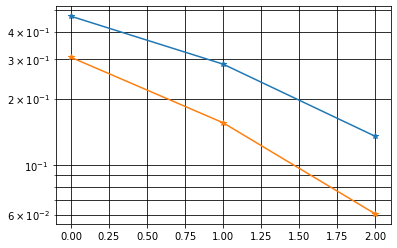

In [9]:
plt.plot(test_nframe/(batch_size*(batches_test/len(ebn0))),marker='*')
plt.plot(CS_test_nframe/(batch_size*(batches_test/len(ebn0))),marker='*')
plt.grid(which='major',color='black',linestyle='-')
plt.grid(which='minor',color='black',linestyle='-')
plt.yscale('log')